# Performance Gap in NYC High Schools: is school education still segregated?

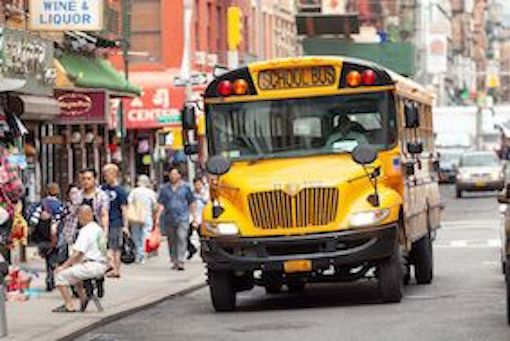

<div style="text-align: right"> Source: Daily News 2021 </div>

## Introduction

The New York City public school system is the largest in the country, with more than 1 million students in grades pre kindergarten through 12 in more than [1,600 schools](https://www.manhattan-institute.org/standardized-testing-student-achievement-new-york-schools). Despite its metropolitan status and substantial amount of resources it is presumed to be [the most segregated school system](https://www.nytimes.com/2021/01/29/nyregion/nyc-mayoral-race-school-segregation.html) in the USA.

Main goal of that project is to *find factors that contribute to high academic performance* in the New York City public schools and how is it distributed throughout the city. The conclusion can contribute to better ressources allocation for educational programs of local authorities and non-profit foundations.  

In course of the project I'll find answer to the following questions:

 - how other learning activities are connected to high academic performance
 - are there factors in learning environment that can affect academic performance
 - how do demographic factors as race, gender as well as income affect academic performance
 
### What is SAT?

As the primary parameter to assess academic performance of senior grade students I will use **Scholastic Aptitude Test score (SAT)**. It is a multiple-choice, pencil-and-paper test with three sections: 
 - Math
 - Evidence-Based Reading
 - Writing. 
 
Each of these sections is scored on a scale of 200 to 800 – so a “perfect score” would be 2400. The national average is [1500](https://info.methodtestprep.com/blog/bid/85068/What-is-a-Good-SAT-score-or-ACT-Score#:~:text=There%20are%20three%20sections%20on,is%201500%2C%20as%20of%202011.), as of 2011. 



### Key findings

Academic performance varies greatly across New York City’s public high schools. Achievement gap exists between Hispanic, black students on one side and white, asian students on the other side. The reasons for that are mainly social: low SAT scores correlate with low income and probably also poor English competence that is widespread among fresh migrant families.

## Data sets

New York City regularly publishes data on high school students SAT scores, along with other data sets on high school evaluation. 

In course of the project I'll use following data sets:

 - [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) SAT scores for each high school of NYC for 2012.
 - [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) Information on class size for each school of NYC for 2010-2011.
 - [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) Advanced Placement (AP) exam results for each high school of NYC (passing an optional AP exam in a particular subject can earn a student college credit in that subject) for 2010-2011.
 - [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) the percentage of students who graduated, and other outcome information for each high school of NYC for 2005-2010.
 - [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) demographics information for each high school in NYC for 2006 - 2012.
 - [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) Surveys of parents, teachers, and students at each high school taken in 2011.
 - [School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) directory with basic information on NYC schools for 2014-2015.


## Data cleaning and preparation

I use several data sets with different data and file formats (csv and txt). So the necessary step to enable analysis is to clean data and merge to a single dataframe.

At first I will read every *csv* file and store them as dataframes into a dictionary.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline
plt.style.use('fivethirtyeight')

data_files = [
    'ap_results.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'sat_scores.csv',
    'hs_directory.csv'
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d

### Survey data sets

Every year, all parents, all teachers, and students in grades 6 - 12 take the NYC School Survey. The results provide insight into a school's learning environment. Survey questions assess the following parameters with scores from 1 to 10:
 - safety and respect
 - communication
 - engagement
 - academic expectations

Both of school survey files *survey_all.txt* and *survey_d75.txt* are tab delimited and encoded with Windows-1252 encoding. I open them and add a number of fields to the `data` dictionary. 

Below are the names of the columns with short description taken from [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8):

 - `dbn`- identification code (district borough number)
 - `rr_s`- Student Response Rate
 - `rr_t`- Teacher Response Rate
 - `rr_p`- Parent Response Rate
 - `N_s`- Number of student respondents
 - `N_t`-	Number of teacher respondents
 - `N_p`-	Number of parent respondents
 - `saf_p_10`- Safety and Respect score based on parent responses
 - `com_p_10`- Communication score based on parent responses
 - `eng_p_10`-	Engagement score based on parent responses
 - `aca_p_10`-	Academic expectations score based on parent responses
 - `saf_t_10`-	Safety and Respect score based on teacher responses
 - `com_t_10`-	Communication score based on teacher responses
 - `eng_t_10`-	Engagement score based on teacher responses
 - `aca_t_10`-	Academic expectations score based on teacher responses
 - `saf_s_10`-	Safety and Respect score based on student responses
 - `com_s_10`-	Communication score based on student responses
 - `eng_s_10`-	Engagement score based on student responses
 - `aca_s_10`-	Academic expectations score based on student responses
 - `saf_tot_10`-	Safety and Respect total score
 - `com_tot_10`-	Communication total score
 - `eng_tot_10`-	Engagement total score
 - `aca_tot_10`-	Academic Expectations total score

In [2]:
# open txt files
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

# select necessary fields
survey_fields = [
    'dbn', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]

# create dataframe with target fields
survey = survey.loc[:,survey_fields]
data['survey'] = survey

### Add DBN column to hs_directory

Each school in New York City has a unique code called a DBN, or *district borough number*. Each data set has either a DBN column, or the information to create one. 
I will use a DBN column to combine the data sets. 

In [3]:
# create a single column with dbn number
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

### Convert to numeric
To ensure adequate calculations I will convert several columns from 'sat_scores' and 'ap_results' to numeric. That will also enable calculation of total SAT scores. 

In [4]:
# convert target columns from 'sat_scores' to numeric 
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_scores"][c] = pd.to_numeric(data["sat_scores"][c], errors="coerce")

data['sat_scores']['sat_score'] = data['sat_scores'][cols[0]] + data['sat_scores'][cols[1]] + data['sat_scores'][cols[2]]

In [5]:
# convert target columns from 'ap_results' to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_results'][col] = pd.to_numeric(data['ap_results'][col], errors='coerce')

### Select target data

The data sets used in the project include several different types of schools. 
Next step is to select data on high school general education programs for latest available years (2011-2012 or 2010).

In [6]:
# select target data for high schools
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# calculate average class size for each school
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

# select target data from 'demographics' and 'graduation'
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

# separate the latest year from 'graduation'
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006'] # Cohort of 2006 graduated at 2010
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

### Combine datasets

 I rename columns from 'hs_directory' and 'survey' to keep consistent names for the key field 'DBN' and merge all data sets to one.
Now everything is ready for an exploratory analysis.

In [7]:
# rename columns
data['hs_directory'].rename(columns={'dbn':'DBN'}, inplace=True)
data['survey'].rename(columns={'dbn':'DBN'}, inplace=True)

# left join 'sat_scores' with two other datasets
combined = data['sat_scores']

combined = combined.merge(data['ap_results'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

# join merged dataframe with the rest of datasets
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')
    
# fill in nan values with mean values or 0
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Exploratory analysis of data set

## Finding correlations
Correlation matrix enables fast overview of all the fields in the data set and shows factors with strong correlation to SAT test performance.

In [8]:
# create correlation matrix
correlations = combined.corr()
correlations = correlations['sat_score']
correlations.dropna(inplace=True)

In [9]:
# show top 20 factors with strongest positive and negative correlation
top_pos = correlations.sort_values(ascending=False).head(20)
print(top_pos)
top_pos_list = top_pos.index.to_list()[0:20]
print('\n')
top_neg = correlations.sort_values(ascending=False).tail(20)
print(top_neg)
top_neg_list = top_neg.index.to_list()[0:20]
top_list = top_pos_list + top_neg_list + survey_fields[1:]
top_list = top_list + ['DBN', 'female_per', 'boro', 'SCHOOL NAME', 'AVERAGE CLASS SIZE']

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Total Regents - % of cohort             0.667603
white_per                               0.620718
Total Grads - % of cohort               0.584234
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Total Regents - % of grads              0.494732
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
Name: sat_score, dty

Among factors with strongest correlation to high SAT scores there are several groups:

 - other forms to evaluate academic performance (Advanced Regents diplomas, AP Test Takers, percentage of graduated students)
 - demographic factors (racial group, percentage of students who get free lunches)

I'll also examine how much the school environment affects academic performance. Neither of the factors evaluated in the school survey showed significant correlation to SAT scores, but usually they are regarded as very important by school authorities.

### Delete unnecessary columns

In the merged dataset there are 160 columns now. Now it is clear which columns interest me the most, so I can delete unnecessary ones. 

In [10]:
# delete columns
combined = combined[top_list]

# Patterns of academic motivation
Here I will investigate factors that are connected to a student's academic motivation. Most of them showed high correlation to SAT performance.

## Advanced Regents and Regents diplomas 

The factor that had had highest correlation coefficients to high SAT performance: **Advanced Regents diplomas**. 

In New York State, students can earn [three types of diplomas:](https://www.schools.nyc.gov/learning/student-journey/graduation-requirements)

- A Regents diploma 
- An advanced Regents diploma 
- A local diploma 

All of these diplomas are valid high school diplomas, but graduation with local diplomas is only possible in some special cases (e.g. disabilities). Students who plan to graduate must earn specific course credits and pass specific Regents exams. An **advanced Regents diploma** lets students show additional skills in math, science, and languages other than English.

As far as Regent exams are included in graduation requirements, a strong correlation to percentage of graduated students is expected.

## AP tests

The AP tests were developed in the United States to help high school students prepare for college by taking advanced courses, with no set program of courses. Students could take just one or even a dozen AP classes, depending on their school, schedule, and goals and earn college credit.
AP tests are also correlated with high SAT scores and with high graduation rates.

## Are they various ways to measure academic performance?

Next step is to check how all these factors (SAT score performance, AP test takers, Regents and Advanced Regents exams) connected to each other and to graduation success.

In [11]:
# create correlation matrix
acad_corr = combined.loc[:, ['sat_score', 'Advanced Regents - % of cohort', 
                             'Total Regents - % of cohort', 'Total Grads - % of cohort', 'AP Test Takers ']]
correlations = acad_corr.corr()

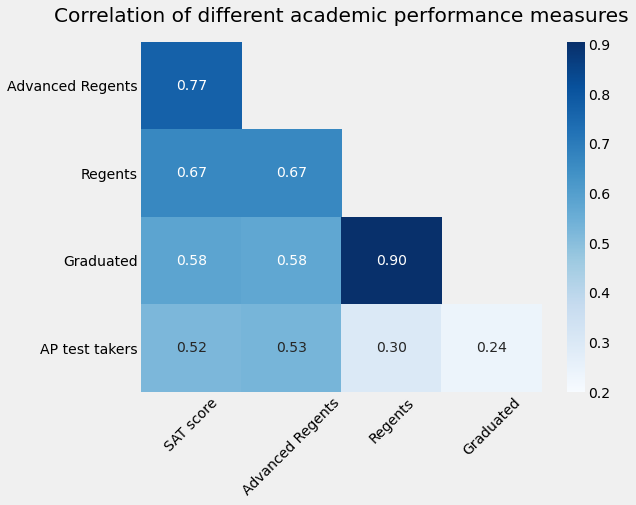

In [12]:
plt.subplots(figsize=(8, 6))

# create mask with half of the matrix
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# adjust mask and dataframe deleting the main diagonal row
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()

# plot heatmap
sns.heatmap(corr, annot=True, vmin= 0.2, fmt='.2f', cmap='Blues', 
            xticklabels=['SAT score', 'Advanced Regents', 'Regents', 'Graduated'], 
            yticklabels=['Advanced Regents', 'Regents', 'Graduated', 'AP test takers'], mask=mask)
plt.xticks(rotation=45)
plt.title('Correlation of different academic performance measures', pad=20)

plt.show()

Indeed Regent diplomas as a necessary requirement are highly correlated to graduation, while high SAT performance and Advanced Regent diplomas are more strongly correlated to each other. 

They can be regarded as a way to measure academic *over-performance*, while Regent diplomas form a *baseline* enabling students to graduate.

AP tests seem to correlate significantly less to other academic performance measures. Let's examine them in detail.

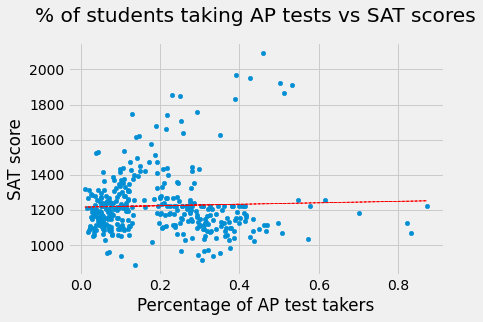

In [13]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_students']

# create scatter plot
combined.plot('ap_per', 'sat_score', kind='scatter')
plt.xlabel('Percentage of AP test takers')
plt.ylabel('SAT score')
plt.title('% of students taking AP tests vs SAT scores', pad=20)

#add trendline
z = np.polyfit(combined['ap_per'], combined['sat_score'], 1)
p = np.poly1d(z)
plt.plot(combined['ap_per'], p(combined['ap_per']), 'r--', linewidth=0.8)

plt.show()

There are two clusters of schools:
 - for a number of schools with above-average SAT scores more students positive correlation looks stronger
 - for another group of schools the higher percentage of AP exam takers (above 20%) does not come with higher SAT scores

Let's have a look at the group with more than half of students taking AP tests. SAT performance there is below average. Is there a pattern, why so many students there opt for AP courses?

In [14]:
combined[combined['ap_per'] > 0.5]['SCHOOL NAME']

6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
39                   UNITY CENTER FOR URBAN TECHNOLOGIES
43        REPERTORY COMPANY HIGH SCHOOL FOR THEATRE ARTS
50                        HUMANITIES PREPARATORY ACADEMY
83             HIGH SCHOOL FOR EXCELLENCE AND INNOVATION
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
208                              FRANCES PERKINS ACADEMY
209              EL PUENTE ACADEMY FOR PEACE AND JUSTICE
219       FREDERICK DOUGLASS ACADEMY IV SECONDARY SCHOOL
222               THE BROOKLYN ACADEMY OF GLOBAL FINANCE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
Name: SCHOOL NAME, dtype: object

Part of these high schools is [**transfer schools**](https://www.schools.nyc.gov/enrollment/other-ways-to-graduate/transfer-high-schools). That means that their programs are specially designed to re-engage high school students who have dropped out or fallen behind in credits. 
 
Second part of them are migrant-oriented or highly specialized high schools. Part of their strategy is to increase number of AP courses and ['to encourage any hard-working students, not just high-achievers, to take more challenging classes.'](https://professionals.collegeboard.org/testing/states-local-governments/partnerships/nyc/ap-all)
 
So **AP exams** could be regarded as an alternative form to increase chances of graduation that is taken as an adaptive strategy to integrate students that are either good in very specific areas or are more challenged with learning English (mostly from the migrant families).
 
Next step is to check how the school environment influences academic performance.


# Learning environment factors

School environment presumed to have a significant effect on academic success and wellbeing (Determan et al., 2019). There are diverse physical and social components of it, starting from design of learning space and class sizes to relationships with teachers and peers. But how are these factors relevant for NYC high schools?

I will approach this topic analyzing data from the high school survey and also take a look at class sizes. 
 
### Find correlations with survey evaluations
 
I will make a short reminder about the survey data. Teachers, students and parents of public high schools were asked to evaluate their school for 4 following parameters:
 - safety and respect (`saf_t`, `saf_s`, `saf_p` and `saf_tot`)
 - communication (`com_t`, `com_s`, `com_p` and `com_tot`)
 - engagement (`eng_t`, `eng_s`, `eng_p` and `eng_tot`)
 - academic expectations (`aca_t`, `aca_s`, `aca_p` and `aca_tot`)
 
Let's check if there is correlation of SAT performance with any of these parameters.

In [15]:
# Remove DBN from list of survey fields
survey_fields.remove('dbn')

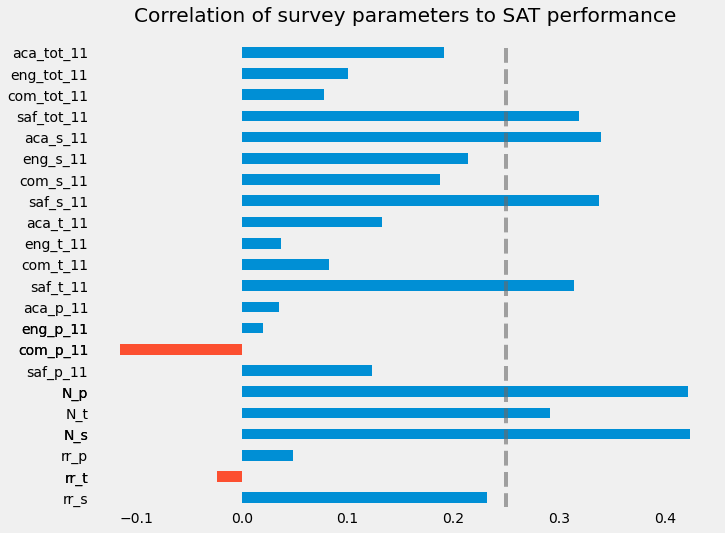

In [16]:
correlation = combined.corr()['sat_score'][survey_fields]
# create a mask
negative = correlation < 0

plt.figure(figsize=(10, 8))

#plot horizontal bar chart

correlation.plot.barh(color = negative.map({True: '#fc4f30', False:'#008fd5'}))
plt.title('Correlation of survey parameters to SAT performance', pad=20)
plt.axvline(0.25, color="dimgray", alpha=0.6, linestyle="--")
plt.grid(False)
plt.show()

Top factors having highest positive correlation with high SAT scores were *number of students and parents that took part in survey* (`N_p` and `N_s`). Probably the main point here is a total number of enrolled students. I will examine that hypothesis further in connection to the class sizes.
 
Another significant factor is high safety and respect levels: high safety and respect estimations by students (`saf_s_11`) and teachers (`saf_t_11`) are moderately correlated with high SAT performance.
 
What is especially interesting, that high academic expectations from teachers (`aca_t_11`) or parents (`aca_p_11`) very slightly correlate to actual performance while students' expectations (`aca_s_11`) do.
 
### What makes a good school environment?

Most environment parameters don't show significant correlation to high SAT performance. But how are these parameters related to each other?

In [17]:
# create correlation matrix for total parameters
survey_corr = combined.loc[:, ['saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']]
correlations = survey_corr.corr()

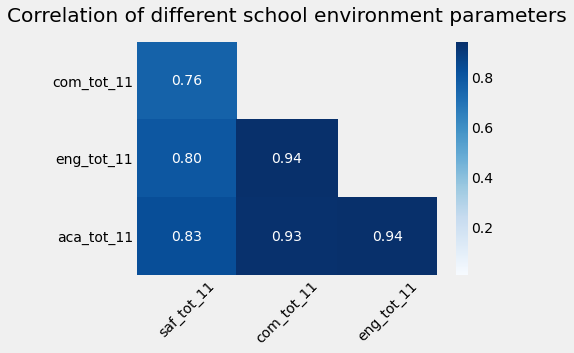

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

# create mask with half of the matrix
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# adjust mask and dataframe deleting the main diagonal row(разобраться)
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='Blues', vmin=0.01)
plt.title('Correlation of different school environment parameters', pad=20)
plt.xticks(rotation=45)

plt.show()

3 parameters show more strong covariance with each other: coefficients for engagement, communication and academic expectations all are over 0.9. Probably these factors show how comfortable the environment is for its members (first of all parents and teachers), but it doesn't affect the academic performance of the students.

Key parameters are safety and respect and presumably the size of the school. At first let's look in detail at the safety parameters. 
 
## Evaluating safety and respect factor

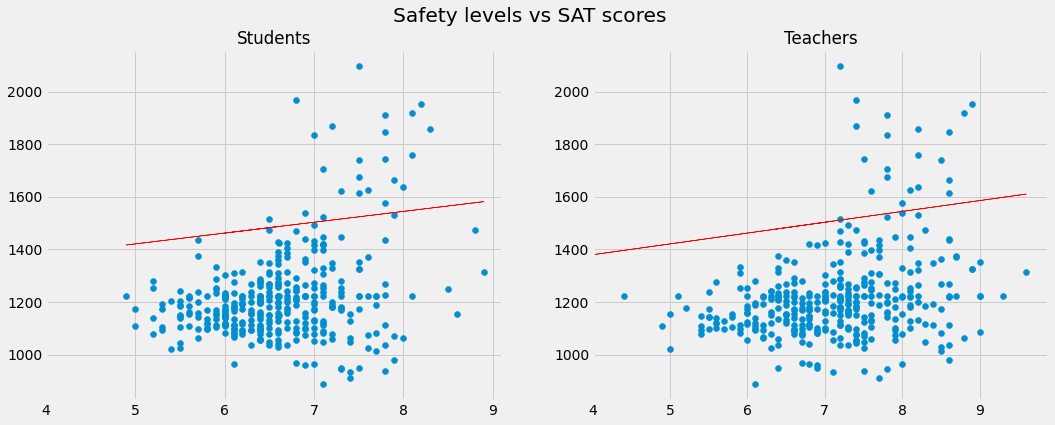

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Safety levels vs SAT scores', fontsize='x-large')

# plot first scatter plot
ax1.scatter(combined['saf_s_11'], combined['sat_score'])
ax1.set_title('Students', fontsize='large')
ax1.set_xlim(4)

# add first trend line
z1 = np.polyfit(combined['saf_s_11'], combined['sat_score'], 1)
p1 = np.poly1d(z1)
ax1.plot(combined['saf_s_11'], p(combined['saf_s_11']), 'r-', linewidth=0.7)

# plot second scatter plot
ax2.scatter(combined['saf_t_11'], combined['sat_score'])
ax2.set_title('Teachers', fontsize='large')
ax2.set_xlim(4)

# add second trend line
z2 = np.polyfit(combined['saf_t_11'], combined['sat_score'], 1)
p2 = np.poly1d(z2)
ax2.plot(combined['saf_t_11'], p(combined['saf_t_11']), 'r-', linewidth=0.7)

The correlation of safety estimations made by students and teachers doesn't show distinct groups and doesn't differ strongly one from another. Let's check what that correlation looks like at the borough level.

### SAT scores vs safety levels by boroughs

New York City is composed of five boroughs:
 - Brooklyn
 - Bronx
 - Manhattan
 - Queens
 - Staten Island.

Each of the New York boroughs is a “city within a city” with its own character.

How do safety at schools and SAT performance differ throughout boroughs?

In [20]:
group_boro = combined.groupby(["boro"]).mean()

# mean SAT scores by borough
print(group_boro['sat_score'].sort_values(ascending=True))

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64


In [21]:
# mean safety and respect estimations by borough
print(group_boro['saf_tot_11'].sort_values(ascending=True))

boro
Brooklyn         7.129245
Staten Island    7.200000
Bronx            7.322581
Queens           7.387500
Manhattan        7.473333
Name: saf_tot_11, dtype: float64


### Observations
Schools from Bronx and Brooklyn with the lowest mean SAT scores also are evaluated with lower safety levels. 

High schools at Queens and Manhattan got higher safety ratings also having higher SAT scores. 

Interesting exception from that trend is a borough of *Staten Island* which was evaluated with low safety levels while having over-average SAT scores. Let's check schools from Staten Island in detail.

Text(0.5, 0, 'Safety score')

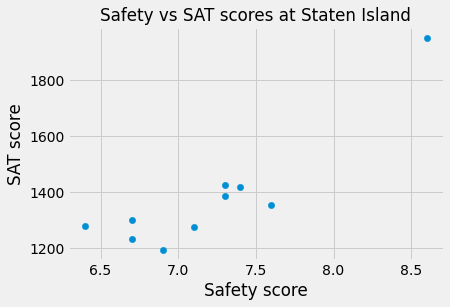

In [22]:
st_island = combined[combined['boro'] == 'Staten Island']

# plot scatter plot
st_island.plot('saf_tot_11', 'sat_score', kind='scatter', s=40)
plt.title('Safety vs SAT scores at Staten Island', fontsize='large')
plt.ylabel('SAT score')
plt.xlabel('Safety score')

In [23]:
print(st_island[st_island['sat_score'] > 1600][['DBN', 'SCHOOL NAME', 'sat_score', 'saf_tot_11']])

        DBN                          SCHOOL NAME  sat_score  saf_tot_11
356  31R605  STATEN ISLAND TECHNICAL HIGH SCHOOL     1953.0         8.6


The only borough that doesn't follow the trend, Staten Island, has few schools - 10 (at least in that dataset), with one clear outlier with the high levels of SAT scores and high level of safety (Staten Island Technical High School). Probably its SAT scores affect average values stronger than safety levels.

The different size of the boroughs make it difficult to make comparisons. Next I will plot the map with more fine-grained spatial distribution - at the level of zip codes.

### Mapping the safety levels and SAT scores
 
The shapefile of zip codes borders of New York City was downloaded from the NYC OpenData portal [here](https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_ZipCodeBoundaries.md). 

I have placed a folder with all files included in the shapefile to the folder 'schools' and read nyu_2451_34509.shp file.
 
I will use the `geopandas` library which enables me to work with shapefiles and process them in the similar way to pandas dataframes.

In [24]:
# read shapefile and create gdf
shapefile = 'schools/ny-zip/nyu_2451_34509.shp'
zip_map = gpd.read_file(shapefile)

In [25]:
# convert zip codes to integers
zip_map['zcta'] = zip_map['zcta'].astype('int64')

In [26]:
# calculate average safety score for every zip code
avg_saf = pd.pivot_table(combined, values='saf_tot_11', index=['zip'], aggfunc=np.mean)
avg_saf.reset_index(inplace=True)

In [27]:
# calculate average SAT score for every zip code
avg_sat = pd.pivot_table(combined, values='sat_score', index=['zip'], aggfunc=np.mean)
avg_sat.reset_index(inplace=True)

In [28]:
# merge two datasets based on zip codes
merged = zip_map.set_index('zcta').join([avg_sat.set_index('zip'), avg_saf.set_index('zip')])

merged.drop(columns='note', inplace=True)
merged.reset_index(inplace=True)

merged['coords'] = merged['geometry'].apply(lambda x:x.representative_point().coords[:])

Text(10, 10, 'Source: NYC OpenData portal 2014')

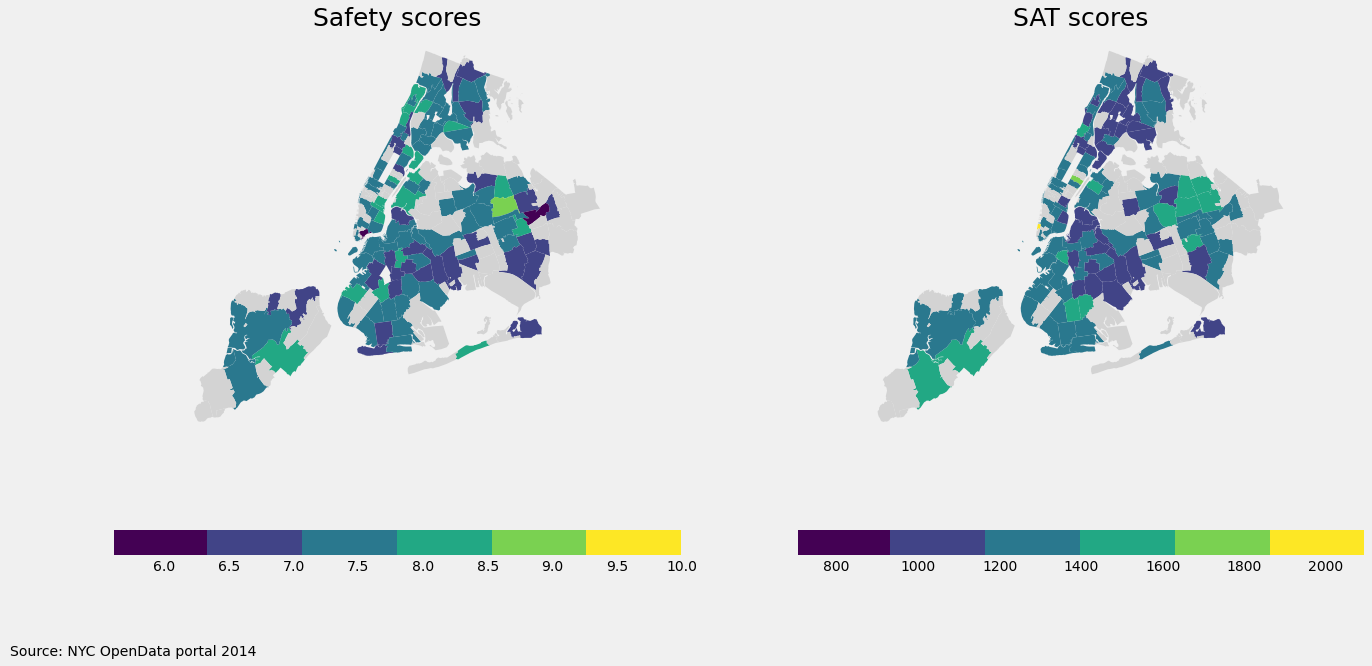

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# plot first map
colormap = plt.cm.get_cmap('viridis', 6)
merged.plot(column='saf_tot_11', ax=ax1, cmap=colormap, vmax=10, legend=True,  
            legend_kwds={'orientation': "horizontal"},
            missing_kwds={'color': 'lightgrey'})
ax1.axis('off')
ax1.set_title('Safety scores', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
# plot second map
merged.plot(column='sat_score', ax=ax2, cmap=colormap, 
            vmin=700, vmax=2096,
            legend=True, legend_kwds={'orientation': "horizontal"}, 
            missing_kwds={'color': 'lightgrey'})
ax2.axis('off')
ax2.set_title('SAT scores', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
ax1.annotate('Source: NYC OpenData portal 2014',
            xy=(10, 10), xycoords='figure pixels')


The distribution of average SAT scores indicates several areas with the **high scores**: 
- north-easten part of Queens
- some areas of Manhattan
- one school at Staten Island.

The districts with **low** SAT scores are:
- Bronx
- eastern part of Brooklyn. 

Based on safety evaluations roughly the same areas as with top average SAT scores are also relatively safe: Manhattan, Staten Island and some north-eastern parts of Queens and the north-western part of Brooklyn (the latest although has slightly lower SAT scores).

High schools in the Bronx are evaluated as relatively safe. That is despite the trend that other boroughs follow is combined with low SAT performance. 

## Average class size - how does it affect SAT performance?

Small class size is often perceived as an indicator of good quality of education (as we can see also in statistical reports from [(Cornelius et al., 2008)](https://files.eric.ed.gov/fulltext/EJ1065420.pdf).

Similarly it is presumed that students perform worse at larger schools whereas smaller schools are seen to have fewer attendance and behavioral issues and better student attitudes, feelings of belonging and connectedness, and extracurricular involvement [(Evans, 2006)](https://www.annualreviews.org/doi/abs/10.1146/annurev.psych.57.102904.190057). 

So regarding my data I would also expect smaller classes as well as smaller schools to be connected to higher SAT performance.

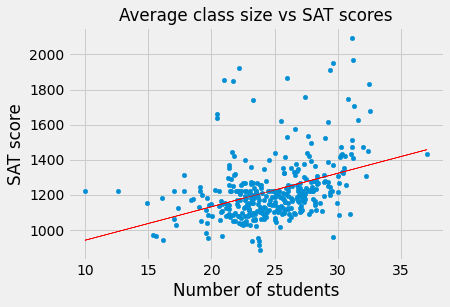

In [30]:
# create scatter plot
combined.plot('AVERAGE CLASS SIZE', 'sat_score', kind='scatter')
plt.title('Average class size vs SAT scores', fontsize='large')
plt.xlabel('Number of students')
plt.ylabel('SAT score')

#add trend line
z = np.polyfit(combined['AVERAGE CLASS SIZE'], combined['sat_score'], 1)
p = np.poly1d(z)

plt.plot(combined['AVERAGE CLASS SIZE'], p(combined['AVERAGE CLASS SIZE']), 'r-', linewidth=0.7)

The scatter plot reveals an interesting trend: class size has a positive correlation to SAT scores, so our hypothesis was not confirmed by the data. 

Let's check the group of schools with average class sizes < 20 and a low SAT performance. Are there any peculiarities that can affect that relationship? 

In [31]:
combined[(combined['AVERAGE CLASS SIZE']<20)&(combined['sat_score']<1200)]['SCHOOL NAME']

6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
8                                   ESSEX STREET ACADEMY
35                                  VANGUARD HIGH SCHOOL
55          URBAN ASSEMBLY SCHOOL FOR MEDIA STUDIES, THE
68                                 PARK EAST HIGH SCHOOL
91                   INTERNATIONAL COMMUNITY HIGH SCHOOL
106    PABLO NERUDA ACADEMY FOR ARCHITECTURE AND WORL...
108      HOLCOMBE L. RUCKER SCHOOL OF COMMUNITY RESEARCH
126                      BRONX INTERNATIONAL HIGH SCHOOL
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
188                   BROOKLYN INTERNATIONAL HIGH SCHOOL
208                              FRANCES PERKINS ACADEMY
238                           BROOKLYN GENERATION SCHOOL
243    HIGH SCHOOL FOR INNOVATION IN ADVERTISING AND ...
244           CULTURAL ACADEMY FOR THE ARTS AND SCIENCES
246         ACADEMY FOR CONSERVATION AND THE ENVIRONMENT
265               INTERNATIONAL HIGH SCHOOL AT LAFAYETTE
286               PAN AMERICAN 

Whilst some of the schools in that list are more migrant focused (usually include the word 'international'), or tailored for students with special needs (like The American Sign Language and English Secondary school), but the group doesn't consist of them exclusively.

In my opinion, it could also be connected to the trend that larger numbers of students participating in the school survey (that is equal to larger school size) also tend to get higher SAT scores.

Let's check how the school size is correlated to the sat_scores:

In [32]:
combined.corr()['sat_score']['total_students']

0.407827001022494

Moderate positive correlation of school size to high SAT scores could mean that number of peers can influence academic performance and can possibly be connected to class size as well. 
That hypothesis needs to be examined with more data in hands, ideally in chronological perspective for the same schools.

# Demographic factors

Demographic factors that I will examine below and that can be found in my data:
 - gender
 - race group
 - income (closest estimation - percent of students that get reduced/free lunch)
 
 
## Gender difference in SAT performance
 
Next step is to see how gender correlates with high SAT scores.


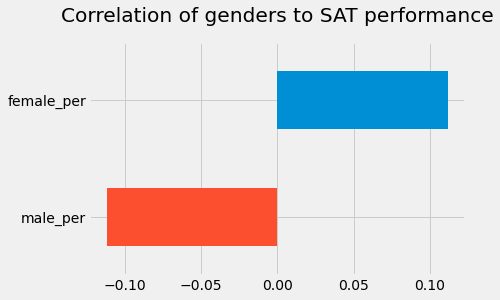

In [33]:
# create bar plot on gender vs SAT scores correlation 
correlation = combined.corr()['sat_score'][['male_per', 'female_per']]

# create a mask
negative = correlation < 0

plt.figure()

# plot horizontal bar chart
correlation.plot.barh(color = negative.map({True: '#fc4f30', False:'#008fd5'}))
plt.title('Correlation of genders to SAT performance', pad=20)
plt.show()

Female gender shows slight positive correlation (with correlation coefficient = 0.1) while male gender - slightly negative (correlation coefficient = -0.1). 

Let's investigate in detail which schools with high SAT performance also include relatively more female students.

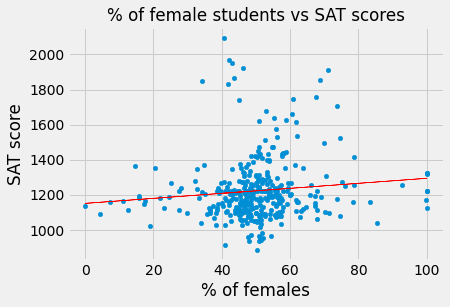

In [34]:
# create scatterplot
combined.plot('female_per', 'sat_score', kind='scatter')
plt.title('% of female students vs SAT scores', fontsize='large')
plt.xlabel('% of females')
plt.ylabel('SAT score')

#add trend line
z = np.polyfit(combined['female_per'], combined['sat_score'], 1)
p = np.poly1d(z)

plt.plot(combined['female_per'], p(combined['female_per']), 'r-', linewidth=0.7)

Most part of schools fall into group with share of female students between *40 and 60%* which is expectable - today schools have mixed-gender classes. 
 
Female gender though doesn't look like a very strong factor for high academic performance.

Let's have a look at schools with the highest share of female students, maybe it's not gender percentages but some other factors are working here?

First, let's take a look at the schools with more than 60% of female students and high levels of SAT performance.

In [35]:
combined[(combined['female_per'] > 60)&(combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These are selective college-preparatory schools, 3 of them are focused on liberal arts education. That specialization usually attracts more female students.

After examining high performers I will check the group of schools with predominantly female students (more than 80%).

In [36]:
combined[combined['female_per'] > 80]['SCHOOL NAME']

15     URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...
49                 THE HIGH SCHOOL OF FASHION INDUSTRIES
70                       YOUNG WOMEN'S LEADERSHIP SCHOOL
71                       YOUNG WOMEN'S LEADERSHIP SCHOOL
104                        WOMEN'S ACADEMY OF EXCELLENCE
133                     HIGH SCHOOL FOR VIOLIN AND DANCE
137    THE MARIE CURIE SCHOOL FOR MEDICINE, NURSING, ...
191    URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...
264       THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE
329              YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS
338             YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA
Name: SCHOOL NAME, dtype: object

Schools with predominance of female students either have specialized programs that usually attract more female students (fashion, music, nursing) or focused exclusively on women education. 
 
Latter schools could be very important to attract girls from traditionalist muslim families for which mixed-gender education could be unecceptable. As is clear from the scatterplot though the SAT performance of students of these schools lay below average. The reasons for that could be a small size of these schools (reduced number of peers?) or another vector of attitudes among students.

Overall the female/male gender doesn't seem to have any significant correlation with academic performance.
 
Next step is to examine how academic performance differs among different race groups of students.

## Does race demographics influence academic performance?

There are a few columns that indicate the percentage of each race at a given school:
 - white_per
 - asian_per
 - black_per
 - hispanic_per
 
By exploring how average SAT scores differ among these groups I'll see if there is any systematic difference. More information on the racial group terminology can be found [here](https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html).

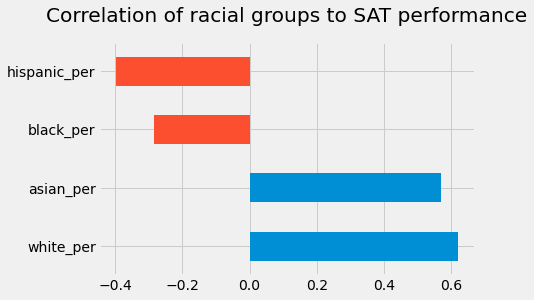

In [37]:
race_groups = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlation = combined.corr()["sat_score"][race_groups]

# create a mask
negative = correlation < 0

plt.figure()

#plot horizontal bar chart
correlation.plot.barh(color = negative.map({True: '#fc4f30', False:'#008fd5'}))
plt.title('Correlation of racial groups to SAT performance', pad=20)
#plt.grid(False)
plt.show()

Based on the plot there is a strong positive correlation with percentage of White and Asian students, while percentage of Hispanic students has some negative correlation with high average SAT scores. Black student proportion also shows moderate negative correlation.

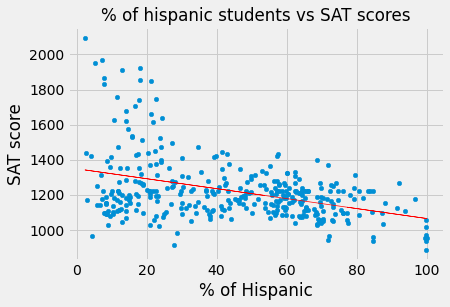

In [38]:
# create scatter plot
combined.plot('hispanic_per', 'sat_score', kind='scatter')
plt.title('% of hispanic students vs SAT scores', fontsize='large')
plt.xlabel('% of Hispanic')
plt.ylabel('SAT score')

#add trend line
z = np.polyfit(combined['hispanic_per'], combined['sat_score'], 1)
p = np.poly1d(z)

plt.plot(combined['hispanic_per'], p(combined['hispanic_per']), 'r-', linewidth=0.7)

There is a strong negative correlation of percentage of Hispanic students to high SAT scores. Starting from more than 25% of hispanic students in the school the average SAT scores are significantly lower. 
 
The group with lowest SAT scores are schools with 100% of hispanic population. Let's have a look at them.

In [39]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

After short research on these schools I found that most of them are aimed at newly arrived migrants and offer programs to learn English. That could easily explain below-average performance at SAT tests.

What about the schools which outperform on SAT and have <20% of hispanic students?

In [40]:
combined[(combined['hispanic_per'] < 20)&(combined['sat_score'] > 1790)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [41]:
combined['sat_score'].describe()

count     363.000000
mean     1223.438806
std       178.223775
min       887.000000
25%      1113.000000
50%      1193.000000
75%      1266.500000
max      2096.000000
Name: sat_score, dtype: float64

Most part of schools in that list are called **public magnets**. These are schools with specialized courses or curricula including advanced college programs. "Magnet" refers to how the schools draw students from across the normal boundaries defined by authorities (usually school boards). Students admitted there should get high notes at Specialized Science High School Admissions test. More information on public magnet schools could be found [there.](https://www.magnetschools.nyc/)
 
Let's see how does racial diversity looks in schools with higher SAT scores.


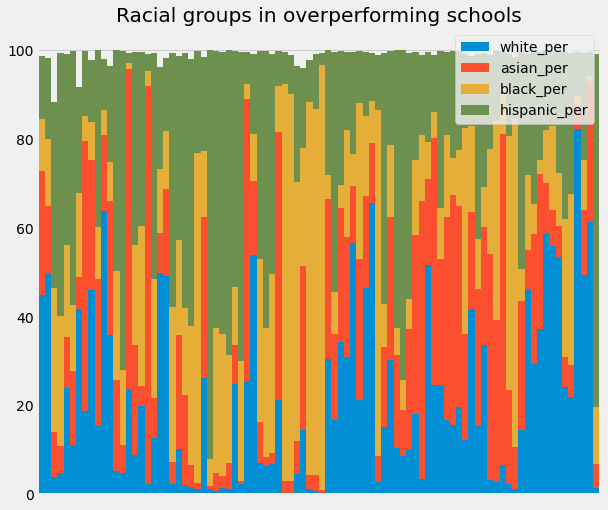

In [42]:
combined[combined['sat_score'] > 1266].plot(x="SCHOOL NAME", y=race_groups, kind="bar", stacked=True, width=1, title='Racial groups in overperforming schools', figsize=(9,8)).axes.get_xaxis().set_visible(False)

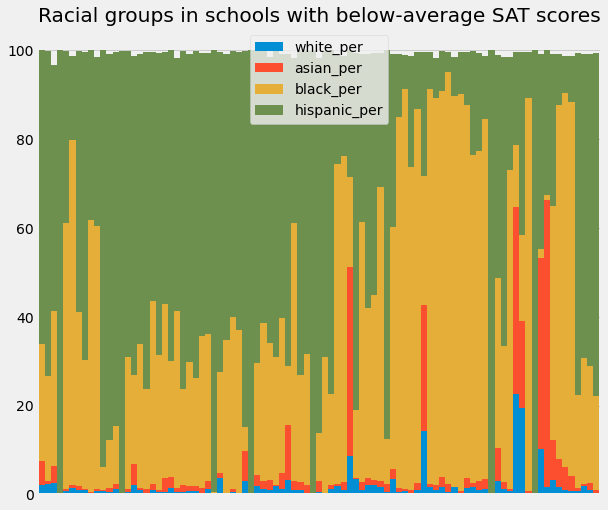

In [43]:

combined[combined['sat_score'] < 1113].plot(x="SCHOOL NAME", y=race_groups, kind="bar", stacked=True, width=1, title='Racial groups in schools with below-average SAT scores', figsize=(9,8)).axes.get_xaxis().set_visible(False)

As we can see over-performers tend to have more asian and white students as schools with below-average SAT scores tend to include predominantly black and hispanic students.
That trend is systemic and applies for the majority of NYC schools. 
What can be the core reason for that? Earlier when I created a map with SAT score distribution several geographical clusters were found with below-average performance. My hypothesis is that there are 2 factors that define strong academic performance: 
- native English
- high household income
 
## Income factors
 
The data that could give some approximation to the socio-economic context in which students live is a percentage of students who get free or reduced lunches. The main condition for that option is a below-average income of the family.
 
### Mapping percentage of students who get free/reduced lunches


In [44]:
# calculate average proportion of free/reduced lunches for every zip code

avg_frl = pd.pivot_table(combined, values='frl_percent', index=['zip'], aggfunc=np.mean)
avg_frl.reset_index(inplace=True)
avg_frl['frl_percent'].describe()

count    116.000000
mean      62.324886
std       15.661436
min       15.800000
25%       52.200000
50%       65.676190
75%       71.855000
max       99.200000
Name: frl_percent, dtype: float64

In [45]:
# calculate average SAT score for every zip code
avg_sat = pd.pivot_table(combined, values='sat_score', index=['zip'], aggfunc=np.mean)
avg_sat.reset_index(inplace=True)

In [46]:
# merge two datasets based on zip codes
merged = zip_map.set_index('zcta').join([avg_sat.set_index('zip'), avg_frl.set_index('zip')])

merged.drop(columns='note', inplace=True)
merged.reset_index(inplace=True)

merged['coords'] = merged['geometry'].apply(lambda x:x.representative_point().coords[:])

Text(10, 10, 'Source: NYC OpenData portal 2014')

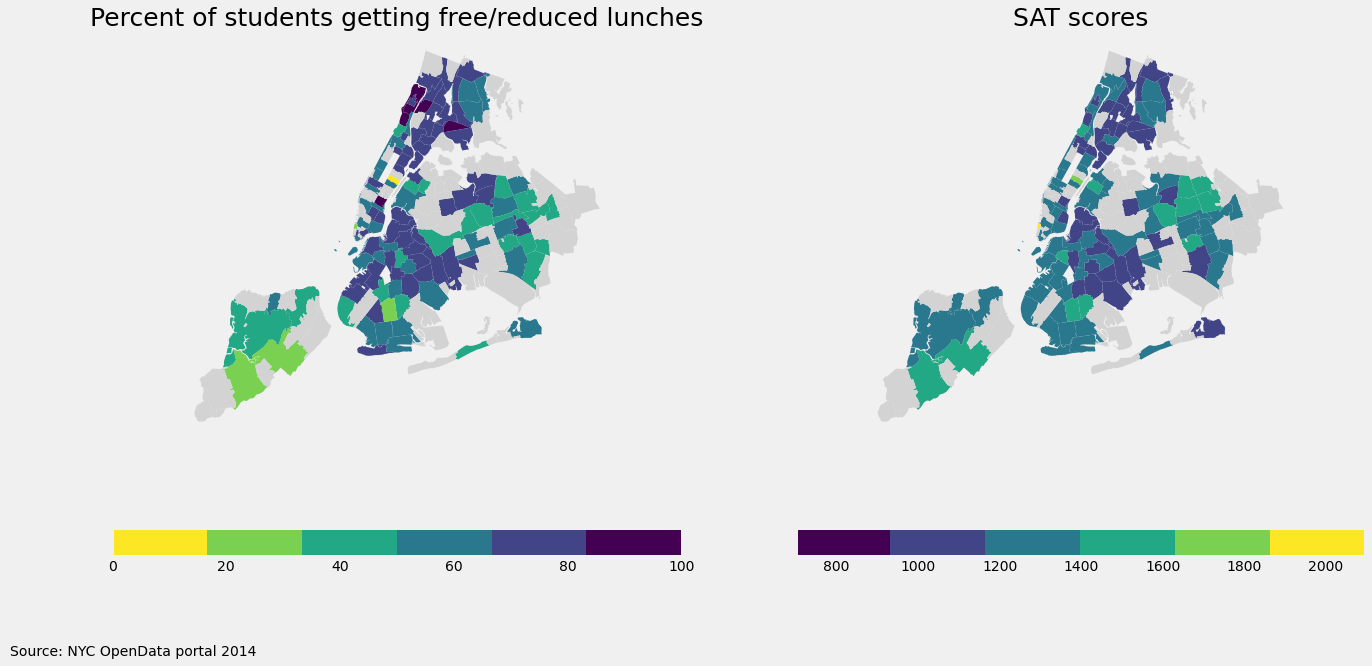

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# plot first map
colormap1 = plt.cm.get_cmap('viridis_r', 6)
merged.plot(column='frl_percent', ax=ax1, cmap=colormap1, legend=True,
            vmin=0, vmax=100,
            legend_kwds={'orientation': "horizontal"},
            missing_kwds={'color': 'lightgrey'})
ax1.axis('off')
ax1.set_title('Percent of students getting free/reduced lunches', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# plot second map
colormap2 = plt.cm.get_cmap('viridis', 6)
merged.plot(column='sat_score', ax=ax2, cmap=colormap2, legend=True,
            vmin=700, vmax=2096,
            legend_kwds={'orientation': "horizontal"}, 
            missing_kwds={'color': 'lightgrey'})
ax2.axis('off')
ax2.set_title('SAT scores', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# add annotation
ax1.annotate('Source: NYC OpenData portal 2014',
            xy=(10, 10), xycoords='figure pixels')

The areas with the highest proportion of students getting free/reduced meals (that happens when the family is low-income) tend to be also areas with lower SAT scores. That is certainly a **systematic gap**, that could also be connected to the migrant status of these families. 

To check these hypotheses I create a correlation matrix between 'sat_scores', 'frl_percent' and 'ell_percent'. The last parameter is a *share of English Language Learners* that could be higher in schools with migrant students.


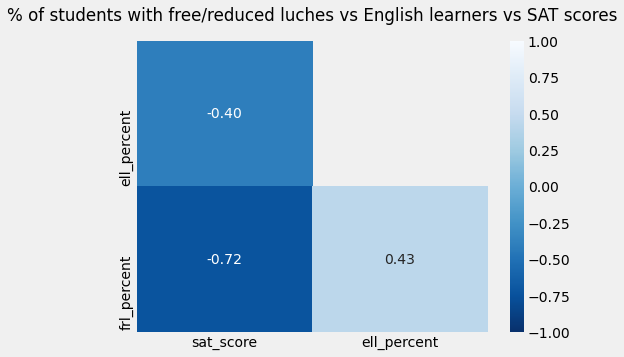

In [48]:
# create correlation matrix
soc_econ_corr = combined.loc[:, ['sat_score', 'ell_percent', 'frl_percent']]
correlations = soc_econ_corr.corr()

fig, ax = plt.subplots(figsize=(7, 5))

# create mask with half of the matrix
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# adjust mask and dataframe deleting the main diagonal row
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='Blues_r',
           vmin=-1, vmax=1)
plt.title('% of students with free/reduced luches vs English learners vs SAT scores', fontsize='large',pad=20)
#plt.xticks(rotation=45)
plt.show()

The income of the family has more impact on SAT test performance as the number of English Language Learners. There could be several explanation for that:

- language proficiency is not the important factor determining academic performance (other observations on migrant-oriented schools don't fully confirm that statement)
- the measure 'ell_percent' doesn't reflect the proportion of migrant students

The social factors as income of the parents seem to correlate strongly with academic performance. It is the strongest factor having negative correlation to high SAT scores, and it often happens within areas with predominance of Hispanic and more rarely Black population.

# Conclusion
 
## What is a high academic performance?
 
High Scholastic Aptitude Test (SAT) scores are not the only way to measure academic performance. Other ways are also the proportion of Advanced Regent and Regent diplomas and graduation rates directly connected to them. Advanced Placement test performance showcases more specialized proficiency and is not so strongly connected to graduation outcomes.
 
## Important factors that are correlated to high SAT scores
 
After examination of measures connected to the school environment and demographics enables me to see that there is a systemic problem with lack of racial diversity at high schools. The result of that system is the following trend: in the areas with compact residence of low-income population, more often consisting of two racial groups the average SAT performance is lower than average. Lack of knowledge of English language could affect migrant students (probably the difference in correlation coefficients between Black/Hispanics can be explained that among the last group there are more newcomers with less English proficiency).

The key factor of a school environment is a high level of safety and respect for students. Other factors don't seem to be so closely connected to high SAT scores.
 
 
## Ways to address this problem and to further investigate it

My short exploratory analysis also showed some steps NYC authorities took to tackle the problem of low high school diversity: 
- public magnet schools aim to overcome the borders of residence areas
- Introduction of more AP courses could also be an alternative strategy to provide in-depth knowledge to the students who have below-average overall academic performance.
 
Further study of the problem should include latest datasets to provide an historic perspective on efficiency of these steps.
